In [1]:
#import libraries
import os
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from tqdm.notebook import tqdm
import pydicom
import numpy as np
import shutil
from PIL import Image
import scipy
import torch 
import torchvision
import torchvision.transforms as transforms
from torchvision import models , datasets
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
import os
from fastai.vision.all import *
print("All modules have been imported")

All modules have been imported


In [2]:
#making the folder
!mkdir "data"
!mkdir "data/0"
!mkdir "data/1"
labels = pd.read_csv("../input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv")

mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘data/0’: File exists
mkdir: cannot create directory ‘data/1’: File exists


In [4]:
main_folder_path = "../input/converteddata/png_data/png_voxel_converted_ds"
main_train_folder_path = os.path.join(main_folder_path  , "train")
for subject in tqdm(os.listdir(main_train_folder_path)):
    subject_folder = os.path.join(main_train_folder_path , subject)
    for mri_type in os.listdir(subject_folder):
        mri_type_folder = os.path.join(subject_folder , mri_type)
        for mri_image in os.listdir(mri_type_folder):
            original_image_path = os.path.join(mri_type_folder , mri_image)
            mri_image = subject +"_"+ mri_type +"_"+ mri_image
            subject_num = int(subject)
            idx = np.where(labels['BraTS21ID'] == subject_num)[0][0]
            label = str(labels.loc[idx , 'MGMT_value'])
            new_image_folder_path =os.path.join("data" , label)
            new_image_path = os.path.join(new_image_folder_path , mri_image)
            shutil.copy(original_image_path , new_image_path)

  0%|          | 0/582 [00:00<?, ?it/s]

In [5]:
print("Images with label 0 = " , len(os.listdir("data/0")) , "Images with label 1 = " , len(os.listdir("data/1")))

Images with label 0 =  39744 Images with label 1 =  44064


In [6]:
for folder in os.listdir("data"):
    folder_name = str(folder)
    path = "data/"+folder_name
    for file in tqdm(os.listdir(path)):
        img = Image.open(path + '/' + file)
        clrs = img.getcolors()
        if len(clrs) == 1:
            os.remove(path + '/' + file)

  0%|          | 0/39744 [00:00<?, ?it/s]

  0%|          | 0/44064 [00:00<?, ?it/s]

# **Model and training classes**

In [7]:
print("Images with label 0 = " , len(os.listdir("data/0")) , "Images with label 1 = " , len(os.listdir("data/1")))

Images with label 0 =  31324 Images with label 1 =  34108


In [8]:
!mkdir "data/TRAIN"
!mkdir "data/TRAIN/1"
!mkdir "data/TRAIN/0"
!mkdir "data/VAL"
!mkdir "data/VAL/0"
!mkdir "data/VAL/1"
!mkdir "data/TEST"
!mkdir "data/TEST/0"
!mkdir "data/TEST/1"

In [9]:
IMG_PATH = "./data"

#split the data into train/test/val
for CLASS in tqdm(["0" , "1"]):
    IMG_NUM = len(os.listdir(IMG_PATH +"/"+ CLASS))
    for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH +"/"+ CLASS)):
            img = IMG_PATH+ '/' +  CLASS + '/' + FILE_NAME
            if n <4000 :
                shutil.copy(img, 'data/TEST/' + str(CLASS) + '/' + FILE_NAME)
            elif n < 0.9*IMG_NUM:
                shutil.copy(img, 'data/TRAIN/'+ str(CLASS) + '/' + FILE_NAME)
            else:
                shutil.copy(img, 'data/VAL/'+ str(CLASS) + '/' + FILE_NAME)


  0%|          | 0/2 [00:00<?, ?it/s]

In [11]:
path=Path('./data')

In [12]:
path.ls()

(#5) [Path('data/TEST'),Path('data/0'),Path('data/1'),Path('data/VAL'),Path('data/TRAIN')]

In [13]:
fields = DataBlock(blocks=(ImageBlock, CategoryBlock),
   get_items=get_image_files,
   get_y=parent_label,
   splitter=RandomSplitter(valid_pct=0.2, seed=42),
   item_tfms=RandomResizedCrop(224, min_scale=0.5),
   batch_tfms=aug_transforms())

In [14]:
dls=fields.dataloaders(path)

In [15]:
dls.vocab

['0', '1']

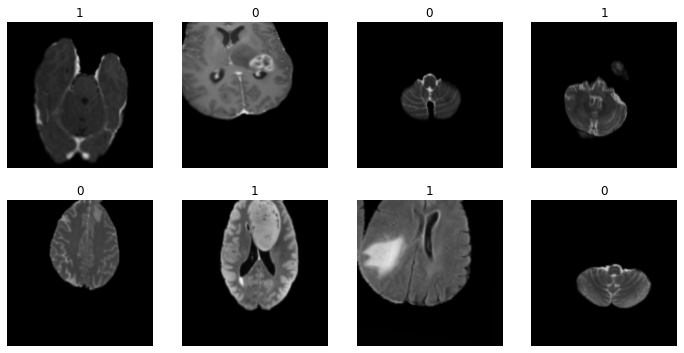

In [16]:
dls.train.show_batch(max_n=8,nrows=2)

In [17]:
learn = cnn_learner(dls, resnet34, metrics=[error_rate, accuracy], model_dir="/tmp/model/").to_fp16()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

SuggestedLRs(lr_min=9.12010818865383e-08, lr_steep=6.309573450380412e-07)

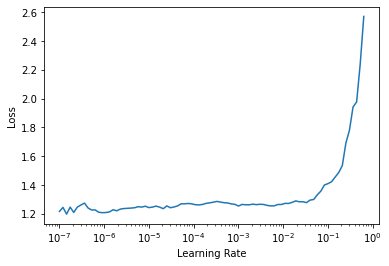

In [18]:
learn.lr_find()

In [19]:
learn.fine_tune(10, base_lr=1e-2)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.706068,0.693519,0.488728,0.511272,06:43


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.685968,0.708028,0.476158,0.523842,08:06
1,0.682780,0.769802,0.476158,0.523842,08:07
2,0.682433,0.804059,0.476158,0.523842,08:05
3,0.666338,0.698333,0.474591,0.525409,08:06
4,0.658439,0.911623,0.476387,0.523613,08:07
5,0.635717,0.847324,0.462173,0.537827,08:06
6,0.617699,0.788299,0.463511,0.536489,08:07
7,0.595394,0.796388,0.446699,0.553301,08:07
8,0.579107,0.823044,0.436841,0.563159,08:07
9,0.578638,0.809638,0.436306,0.563694,08:07


In [ ]:
learn.fit_one_cycle(10, slice(1e-2),cbs=[ShowGraphCallback()])

In [ ]:
# interp = ClassificationInterpretation.from_learner(learn)
# losses,idxs = interp.top_losses()
# len(dls.valid_ds)==len(losses)==len(idxs)
# interp.plot_confusion_matrix()

In [1]:
# #calculating TP,FP,TN,TP
# upp, low = interp.confusion_matrix()
# tn, fp = upp[0], upp[1]
# fn, tp = low[0], low[1]
# print(tn, fp, fn, tp)

In [2]:
# interp.plot_top_losses(6)

# **Model Training**